In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")
import numpy as np
import matplotlib.pyplot as plt

import src.atomic_worlds.big_small as bs
import src.utils.param_sweep as ps
import src.utils.transition_matrix as tm
import src.utils.make_environment as make_env
import src.worlds.mdp2d as mdp2d

from src.utils.visualization import plot_environment
from src.utils.make_environment import transition_matrix, Environment, insert_walls_into_T


In [2]:
# Set the number of scales and gammas to use
granularity = 20  # 5, 10, 20

# Set up parameters to search over
probs = np.linspace(0.4, 0.99, granularity)
gammas = np.linspace(0.4, 0.99, granularity)

In [3]:
def convert_to_environment(world: mdp2d.Experiment_2D):
    """Converts a world to an environment."""
    N = world.height
    M = world.width

    R_dict = world.rewards_dict
    R = np.zeros(N * M)
    for key in R_dict:
        R[key] = R_dict[key]

    T = world.mdp.T

    environment = make_env.Environment(
        N=N,
        M=M,
        T_true=T,
        wall_states=[],
        R_sample_mean=None,
        start_state=0,
        n_walls=0,
        R_true=R,
    )

    return environment

In [10]:
def plot_bmap(
    world: mdp2d.Experiment_2D,
    idx_map=None,
    p2idx_override=None,
    tmatrix_func=tm.id_func,
    start_state=0,
    ax=None,
):
    result = ps.run_experiment(
        experiment=world,
        transition_matrix_func=tmatrix_func,
        params=world.params,
        gammas=gammas,
        probs=probs,
        start_state=start_state,
    )

    data = result.data

    if idx_map:
        new_data = np.zeros_like(data)
        for fromm, to in idx_map.items():
            new_data[data == fromm] = to
        data = new_data

    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    ps.make_general_strategy_heatmap(
        results=data,
        probs=probs,
        p2idx=p2idx_override,
        title=f"",
        ax=ax,
        gammas=gammas,
        annot=False,
        ax_labels=False,
        num_ticks=5,
    )
    return result

## Define BigSmall worlds


In [5]:
height = 3
width = 7

big_small_world = bs.make_smallbig_experiment(
        height=height,
        width=width,
        big_reward=100,
        small_reward_frac=0.5)



big_small_env = convert_to_environment(big_small_world)

In [6]:
p2idx_override_bs = {
    "Close small R": 1,
    "Far large R": 0,
}

idx_map_bs = {0: 1, 1: 0}

In [7]:
from src.worlds.mdp2d import Experiment_2D

wall_states = [7, 8, 9, 10, 14]


def smallbig_reward(
    height: int,
    width: int,
    big_reward: float,
    small_reward_frac: float,
) -> dict:
    """
    Places the small and big rewards in the bottom-left and bottom-right corners, respectively.

    returns a dictionary of rewards for each state in the gridworld.
    """

    reward_dict = {}

    small_reward = big_reward * small_reward_frac

    # Put small reward in lower left corner
    small_reward_state = (height - 1) * width
    reward_dict[small_reward_state] = small_reward

    # Put big reward in lower right corner
    big_reward_state = height * width - 1
    reward_dict[big_reward_state] = big_reward

    return reward_dict

def make_world(
    height: int,
    width: int,
    big_reward: float,
    small_reward_frac: float,
    wall_states: list
) -> Experiment_2D:
    rewards_dict = smallbig_reward(
        height,
        width,
        big_reward,
        small_reward_frac,
    )

    experiment = Experiment_2D(
        height,
        width,
        rewards_dict=rewards_dict,
        wall_states=wall_states
        # transition_mode=TransitionMode.SIMPLE,
    )

    return experiment

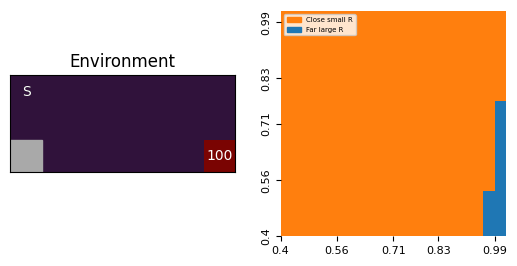

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2)
wall_states = [14]

new_world = make_world(height = height, width=width, big_reward = 100, small_reward_frac=0.5, wall_states=wall_states)
new_env = convert_to_environment(new_world)

plot_environment(new_env.R_true.reshape(height, width), wall_states=wall_states, ax= axs[0])
out = plot_bmap(
    world=new_world,
    idx_map=idx_map_bs,
    p2idx_override=p2idx_override_bs,
    tmatrix_func=tm.id_func,
    ax=axs[1],
)

In [12]:
out

ExperimentResult(data=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0

## Create Custom Worlds

Expectations
- Specify N,M
- Specify Reward for each state
- Specify absorbing states
- Insert wall states